# Visualización de datos COVID-19  Tungurahua

Datos obtenidos del portal de datos abiertos [Ecuacovid](https://github.com/andrab/ecuacovid)
Datos de movilidad obtenidos del portal de Google [COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/)

## Importación de librerías

In [59]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import time
import shutil
import sys

## Obtención de datos
### Actualizar los datos de EcuaCOVID
Este pequeño programa, descarga los datos actualizados(si es que no están actualizados), todos los datos se descargan en formato CSV

In [60]:
!python obtener_datos_actuales.py

Archivo datos_crudos/camas/provincias.csv ha cambiado, actualizando con el repositorio 
Archivo datos_crudos/defunciones/provincias.csv ha cambiado, actualizando con el repositorio 
Archivo datos_crudos/muertes/provincias.csv ha cambiado, actualizando con el repositorio 
Archivo datos_crudos/positivas/provincias.csv ha cambiado, actualizando con el repositorio 
Archivo datos_crudos/vacunometro/provincias.csv ha cambiado, actualizando con el repositorio 


### Descarga datos movilidad
Descarga los datos de movilidad del Portal de Google, si es que los datos existentes superan los 7 días de antiguedad, este dato está en formato CSV

In [61]:
archivo_movilidad = "Region_Mobility_Report_CSVs/2021_EC_Region_Mobility_Report.csv"
url_descargar = "https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip"
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

def descargar_archivo_movilidad():
    print("Descargando archivos actualizados de movilidad")
    if not os.path.exists("Region_Mobility_Report_CSVs.zip"):
        http_response = urlopen(url_descargar)
        zipfile = ZipFile(BytesIO(http_response.read()))
        zipfile.extractall(path="Region_Mobility_Report_CSVs/")
    else:
        shutil.unpack_archive("Region_Mobility_Report_CSVs.zip", "Region_Mobility_Report_CSVs/", "zip") 
    print("Descomprimiendo archivos en Region_Mobility_Report_CSVs/")
    
if os.path.exists(archivo_movilidad):
    tm = os.path.getmtime(archivo_movilidad)
    tiempo_archivo = time.gmtime(tm)
    tiempo_actual = time.gmtime(time.time())
    if (tiempo_actual.tm_mday - tiempo_archivo.tm_mday) > 7:
        print("Actualizando el archivo de Movilidad de Google")
        descargar_archivo_movilidad()
else:
    print("Descargando archivo de movilidad por primera vez")
    descargar_archivo_movilidad()


## Carga de datos
Los datos son cargados del formato csv, en un Pandas DataFrame que es adecuado para el procesamiento y filtrado de datos, la variable `dias_visualizacion` puede ser cambiada para limitar el número de datos a visualizar en las gráficas

In [62]:
#Directorios de datos
archivo_movilidad = "Region_Mobility_Report_CSVs/2021_EC_Region_Mobility_Report.csv"
datos_covid19_tungurahua = {
    "camas" : "datos_crudos/camas/provincias.csv",
    "defunciones" : "datos_crudos/defunciones/provincias.csv",
    "muertes" : "datos_crudos/muertes/provincias.csv",
    "positivas" : "datos_crudos/positivas/provincias.csv" ,
    "vacunometro" : "datos_crudos/vacunometro/provincias.csv",
    "movilidad": archivo_movilidad
}

dias_visualizacion = 275 ## Dias para visualizar

##Cargar los datos en un Archivo DataFrame de Pandas
df_camas_provincia = pd.read_csv(datos_covid19_tungurahua["camas"])
df_defunciones_provincia = pd.read_csv(datos_covid19_tungurahua["defunciones"])
df_muertes = pd.read_csv(datos_covid19_tungurahua["muertes"])
df_positivos = pd.read_csv(datos_covid19_tungurahua["positivas"])
df_vacunometro = pd.read_csv(datos_covid19_tungurahua["vacunometro"])
df_movilidad = pd.read_csv(datos_covid19_tungurahua["movilidad"])


## Filtrado de datos por Tungurahua
Los datos anteriores corresponden a todo el territorio del Ecuador, ahora se aplican los filtros para obtener los datos de Tungurahua.
La variable `dias_promedio_movil` obtiene los promedios móviles de los datos en los días establecidos

In [63]:
df_camas_tungurahua = df_camas_provincia[(df_camas_provincia["provincia"] == "Tungurahua")]
df_defunciones_tungurahua = df_defunciones_provincia[(df_defunciones_provincia["provincia"] == "Tungurahua")]
df_muertes_tungurahua = df_muertes[(df_muertes["provincia"] == "Tungurahua")]
df_positivo_tungurahua = df_positivos[(df_positivos["provincia"] == "Tungurahua")]
df_vacunometro_tungurahua = df_vacunometro[(df_vacunometro["provincia"] == "Tungurahua")]
df_movilidad_tungurahua = df_movilidad[((df_movilidad['sub_region_1']=="Tungurahua") & (df_movilidad['sub_region_2'].isna()))]
## Ordenar aplicar promedios móviles 
dias_promedio_movil = 7
df_positivo_tungurahua_promedio = df_positivo_tungurahua.copy() 
df_positivo_tungurahua_promedio["nuevas"] = df_positivo_tungurahua["nuevas"].rolling(window=dias_promedio_movil, center = True).mean()
df_positivo_tungurahua = df_positivo_tungurahua_promedio.copy() 

## Grafica de Datos
En esta sección, se procede a graficar los datos obtenidos, de acuerdo a los valores establecidos en `dias_visualizacion`
### Muertes en Tungurahua por COVID

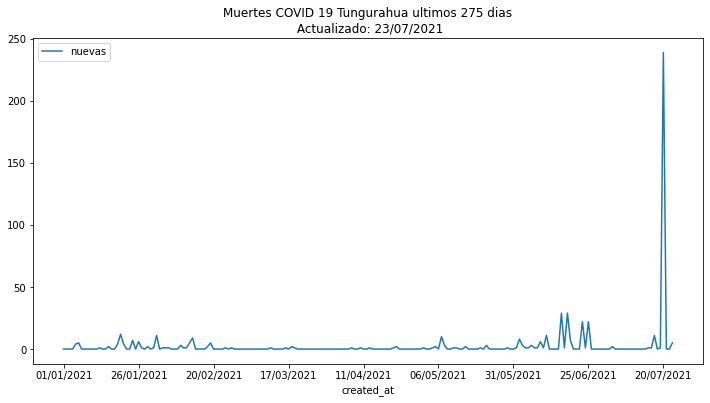

In [64]:
actualizado = df_muertes_tungurahua["created_at"].iloc[-1]
ax = df_muertes_tungurahua.iloc[-dias_visualizacion:].plot.line(x='created_at',y='nuevas', 
                                           title="Muertes COVID 19 Tungurahua ultimos {} dias\n Actualizado: {}".format(dias_visualizacion, actualizado), 
                                           figsize=(12, 6))

## Defunciones

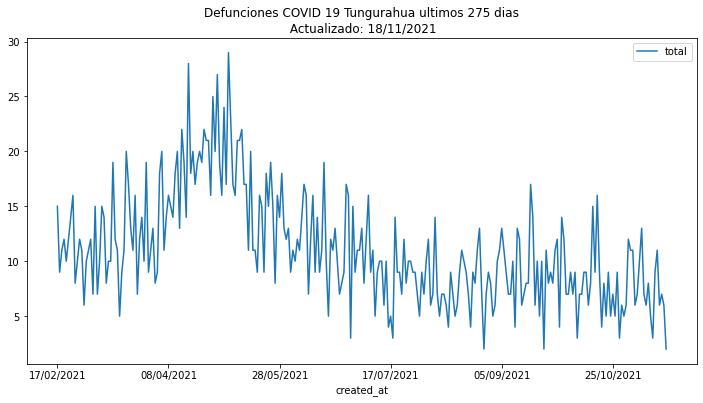

In [65]:
actualizado = df_defunciones_tungurahua["created_at"].iloc[-1]
ax = df_defunciones_tungurahua.iloc[-dias_visualizacion:].plot.line(x='created_at',y='total', 
                                           title="Defunciones COVID 19 Tungurahua ultimos {} dias\n Actualizado: {}".format(dias_visualizacion, actualizado), 
                                           figsize=(12, 6))

## Positivo Tungurahua ultimos 15 dias

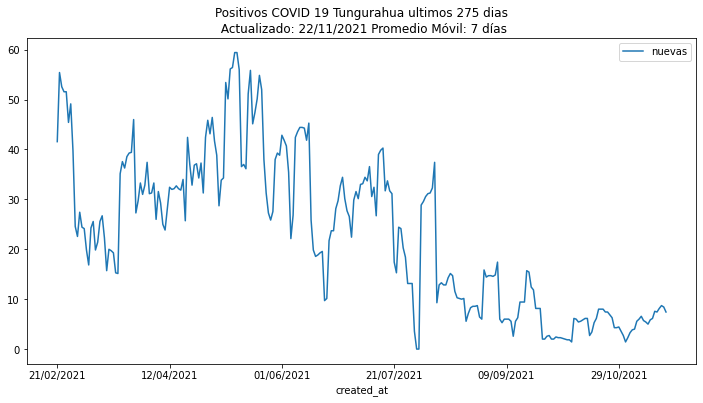

In [66]:
actualizado = df_positivo_tungurahua["created_at"].iloc[-1]
ax = df_positivo_tungurahua.iloc[-dias_visualizacion:].plot.line(x='created_at',y='nuevas', 
                                           title="Positivos COVID 19 Tungurahua ultimos {} dias\n Actualizado: {} Promedio Móvil: {} días".format(dias_visualizacion, actualizado, dias_promedio_movil), 
                                           figsize=(12, 6))

## Vacunometro Tungurahua

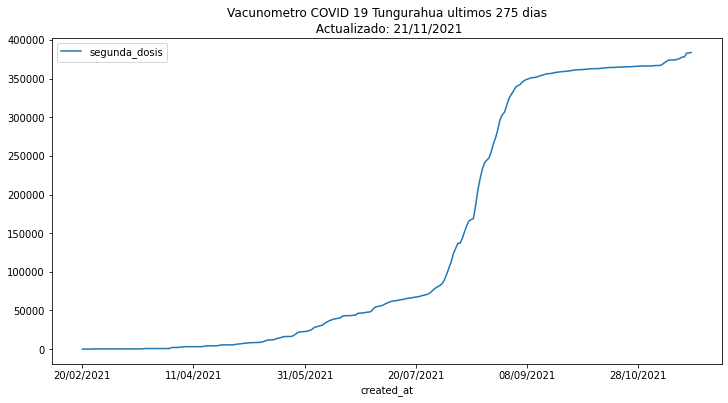

In [67]:
actualizado = df_vacunometro_tungurahua["created_at"].iloc[-1]
ax = df_vacunometro_tungurahua.iloc[-dias_visualizacion:].plot.line(x='created_at',y='segunda_dosis', 
                                           title="Vacunometro COVID 19 Tungurahua ultimos {} dias\n Actualizado: {}".format(dias_visualizacion, actualizado), 
                                           figsize=(12, 6))

## Movilidad en Tungurahua

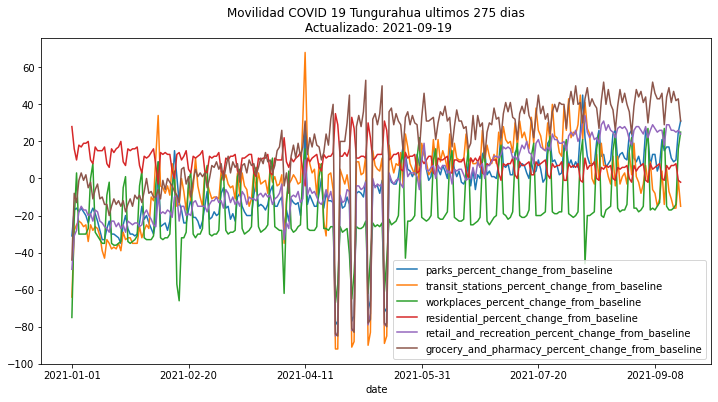

In [68]:
actualizado = df_movilidad_tungurahua["date"].iloc[-1]
lista_etiquetas_y = [
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline",
    "retail_and_recreation_percent_change_from_baseline", 
    "grocery_and_pharmacy_percent_change_from_baseline"
]
ax = df_movilidad_tungurahua.iloc[-dias_visualizacion:].plot.line(x='date', y=lista_etiquetas_y,
                                           title="Movilidad COVID 19 Tungurahua ultimos {} dias\n Actualizado: {}".format(dias_visualizacion, actualizado), 
                                           figsize=(12, 6))

## Composición de los datos
En esta sección, se cambia las fechas de los datos a formato ISO y se seleccionan los fechas de inicio y finales para filtrar todos los datos acorde.

In [69]:
from datetime import date, timedelta

def convertir_dia_mes_año_a_iso(dma):
    #Convierte la fecha en formato dd/mm/aaaa a aaaa-mm-dd y devuelve en datetime
    lista_dma = dma.split("/")
    fecha_iso = "{}-{}-{}".format(lista_dma[-1], lista_dma[1], lista_dma[0])
    return date.fromisoformat(fecha_iso)


#Convertir a formato fecha en ISO
df_movilidad_tungurahua_iso = df_movilidad_tungurahua.copy()
df_vacunometro_tungurahua_iso = df_vacunometro_tungurahua.copy()
df_positivo_tungurahua_iso = df_positivo_tungurahua.copy()
df_defunciones_tungurahua_iso = df_defunciones_tungurahua.copy()

df_movilidad_tungurahua_iso.loc[:, "date"] = df_movilidad_tungurahua["date"].apply(lambda x: date.fromisoformat(x))
df_vacunometro_tungurahua_iso.loc[:, "created_at"] = df_vacunometro_tungurahua["created_at"].apply(lambda x: convertir_dia_mes_año_a_iso(x))
df_positivo_tungurahua_iso.loc[:, "created_at"] = df_positivo_tungurahua["created_at"].apply(lambda x: convertir_dia_mes_año_a_iso(x))
df_defunciones_tungurahua_iso.loc[:, "created_at"] = df_defunciones_tungurahua["created_at"].apply(lambda x: convertir_dia_mes_año_a_iso(x))

#Obtengo las últimas fechas del dataset, para ponerlas todas en el mismo periodo de tiempo
ultima_fecha_movilidad_tungurahua = df_movilidad_tungurahua_iso["date"].iloc[-1]
ultima_fecha_vacunometro_tungurahua = df_vacunometro_tungurahua_iso["created_at"].iloc[-1]
#ultima_fecha_camas_tungurahua = df_camas_tungurahua["created_at"].iloc[-1]
#ultima_fecha_muertes_tungurahua = convertir_dia_mes_año_a_iso(df_muertes_tungurahua["created_at"].iloc[-1])
ultima_fecha_defunciones_tungurahua = df_defunciones_tungurahua_iso["created_at"].iloc[-1]
ultima_fecha_positivo_tungurahua = df_positivo_tungurahua_iso["created_at"].iloc[-1]
fecha_limite_superior = min(ultima_fecha_movilidad_tungurahua, ultima_fecha_vacunometro_tungurahua,
                        ultima_fecha_defunciones_tungurahua, ultima_fecha_positivo_tungurahua)
fecha_limite_inferior = fecha_limite_superior - timedelta(days = dias_visualizacion)



## Guardar los datos
Los datos finales filtrados, en el rango de las fechas establecidas son guardadas en una sola variable y guardados en formato csv con el nombre `datos_regresion_filtrados`

In [70]:
## Guardar los datos en un solo archivo
#serie_filtrada_movilidad_tungurahua = 
serie_filtrada_positivo_tungurahua = df_positivo_tungurahua_iso["nuevas"][(df_positivo_tungurahua_iso["created_at"] <= fecha_limite_superior) & (df_positivo_tungurahua_iso["created_at"] >= fecha_limite_inferior)]
serie_filtrada_defunciones_tungurahua = df_defunciones_tungurahua_iso["total"][(df_defunciones_tungurahua_iso["created_at"] <= fecha_limite_superior) & (df_defunciones_tungurahua_iso["created_at"] >= fecha_limite_inferior)]
serie_filtrada_vacunometro_tungurahua = df_vacunometro_tungurahua_iso["segunda_dosis"][(df_vacunometro_tungurahua_iso["created_at"] <= fecha_limite_superior) & (df_vacunometro_tungurahua_iso["created_at"] >= fecha_limite_inferior)]
serie_filtrada_movilidad_tungurahua = df_movilidad_tungurahua_iso[(df_movilidad_tungurahua_iso["date"] <= fecha_limite_superior) & (df_movilidad_tungurahua_iso["date"] >= fecha_limite_inferior)]
serie_filtrada_fechas_tungurahua = serie_filtrada_movilidad_tungurahua["date"]
serie_filtrada_movilidad_tungurahua = serie_filtrada_movilidad_tungurahua.apply(lambda x: (x['retail_and_recreation_percent_change_from_baseline'] + 
                                            x['grocery_and_pharmacy_percent_change_from_baseline'] + 
                                            x['parks_percent_change_from_baseline'] +
                                            x['transit_stations_percent_change_from_baseline'] +
                                            x['workplaces_percent_change_from_baseline'] + 
                                            x['residential_percent_change_from_baseline'])/6, axis = 1)
#resetear indices
serie_filtrada_movilidad_tungurahua = serie_filtrada_movilidad_tungurahua.reset_index(drop = True)  
serie_filtrada_positivo_tungurahua = serie_filtrada_positivo_tungurahua.reset_index(drop = True)
serie_filtrada_vacunometro_tungurahua = serie_filtrada_vacunometro_tungurahua.reset_index(drop = True)
serie_filtrada_fechas_tungurahua = serie_filtrada_fechas_tungurahua.reset_index(drop = True) 
serie_filtrada_defunciones_tungurahua = serie_filtrada_defunciones_tungurahua.reset_index(drop = True)

series_unidas = {"fecha": serie_filtrada_fechas_tungurahua, "positivo": serie_filtrada_positivo_tungurahua,
               "defunciones": serie_filtrada_defunciones_tungurahua, "vacunometro": serie_filtrada_vacunometro_tungurahua,
               "movilidad": serie_filtrada_movilidad_tungurahua}
datos_regresion_filtrados = pd.DataFrame(data = series_unidas)
datos_regresion_filtrados.to_csv("datos_regresion.csv", index = False)